 Часть 1: Классификация Tiny ImageNet-200 (128×128)
 Своя CNN, ≤5M параметров, вход 128×128×3




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
!unzip -q /content/tiny-imagenet-200.zip -d /content/

replace /content/tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

1. Загрузка и подготовка данных

In [ ]:
DATA_DIR = '/content/tiny-imagenet-200'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DATA_DIR = '/content/tiny-imagenet-200'
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training samples: 1500
Validation samples: 150


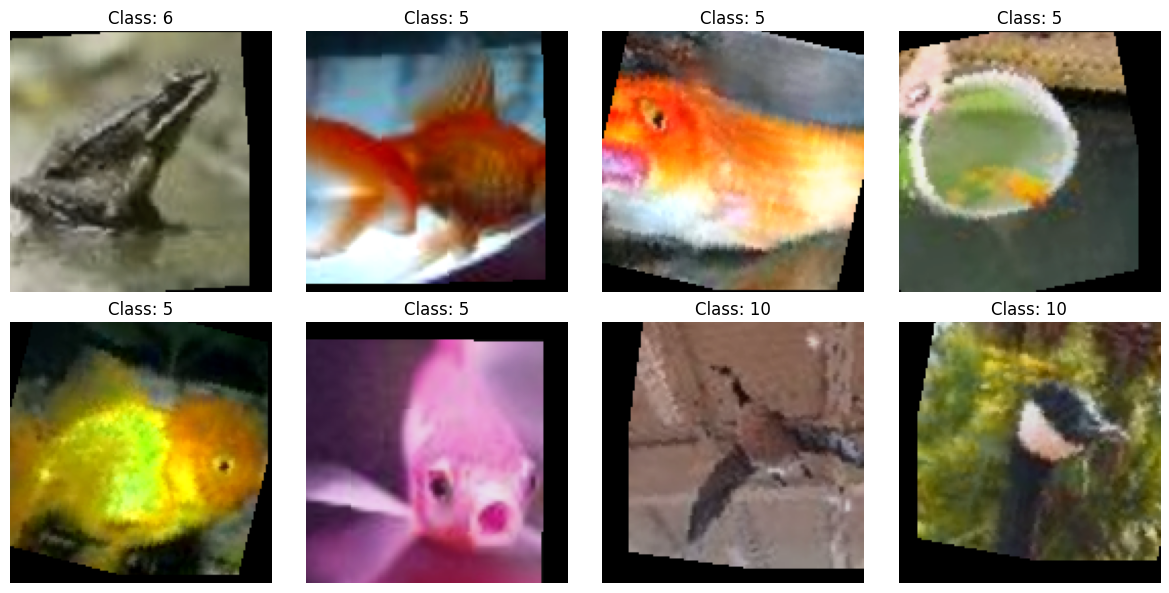

In [ ]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', selected_classes=None, transform=None):
        """
        Args:
            root_dir (str): Путь к корневой директории Tiny ImageNet
            split (str): 'train', 'val' или 'test'
            selected_classes (list): Список выбранных классов (wnid)
            transform: Трансформации для изображений
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.selected_classes = selected_classes

        # Создаем маппинг класс -> индекс
        if selected_classes:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(selected_classes))}
        else:
            # Если классы не указаны, используем все
            all_classes = sorted([d.name for d in (self.root_dir / 'train').iterdir() if d.is_dir()])
            self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}

        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.samples = []
        self._load_samples()

    def _load_samples(self):
        if self.split == 'train':
            train_dir = self.root_dir / 'train'
            for class_name in self.class_to_idx.keys():
                class_dir = train_dir / class_name / 'images'
                if class_dir.exists():
                    for img_path in class_dir.glob('*.JPEG'):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))

        elif self.split in ['val', 'test']:
            val_dir = self.root_dir / 'val'
            annotations_file = val_dir / 'val_annotations.txt'
            if annotations_file.exists():
                with open(annotations_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split('\t')
                        img_name = parts[0]
                        class_name = parts[1]

                        if class_name in self.class_to_idx:
                            img_path = val_dir / 'images' / img_name
                            if img_path.exists():
                                self.samples.append((str(img_path), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

SELECTED_CLASSES = [
    'n01443537', # goldfish
    'n01644900',  # tailed frog
    'n00001740', # entity
    'n00001930', # physical entity
    'n00002137',	# abstraction, abstract entity
    'n00002452',	# thing
    'n00002684',	# object, physical object
    'n01807496',  # partridge
    'n01833805',  # hummingbird
    'n01843383',  # toucan
    'n01855672',  # goose
]

num_classes = len(SELECTED_CLASSES)

train_dataset = TinyImageNetDataset(
    root_dir=DATA_DIR,
    split='train',
    selected_classes=SELECTED_CLASSES,
    transform=train_transform
)

val_dataset = TinyImageNetDataset(
    root_dir=DATA_DIR,
    split='val',
    selected_classes=SELECTED_CLASSES,
    transform=val_transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=4, pin_memory=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
    img = denormalize(img)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Class: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Архитектура

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        out += residual
        return self.relu(out)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout=0.1):
        super(CustomClassifier, self).__init__()

        # Stage 1: 128x128 -> 64x64 (32 channels)
        self.stage1 = nn.Sequential(
            ConvBlock(3, 32, kernel_size=7, stride=2, padding=3),  # 128 -> 64
            ResidualBlock(32, dropout=dropout)
        )

        # Stage 2: 64x64 -> 32x32 (64 channels)
        self.stage2 = nn.Sequential(
            ConvBlock(32, 64, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            ResidualBlock(64, dropout=dropout)
        )

        # Stage 3: 32x32 -> 16x16 (128 channels)
        self.stage3 = nn.Sequential(
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            ResidualBlock(128, dropout=dropout)
        )

        # Stage 4: 16x16 -> 8x8 (256 channels)
        self.stage4 = nn.Sequential(
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            ResidualBlock(256, dropout=dropout)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x1 = self.stage1(x)   # 64x64x32
        x2 = self.stage2(x1)  # 32x32x64
        x3 = self.stage3(x2)  # 16x16x128
        x4 = self.stage4(x3)  # 8x8x256

        x = self.gap(x4)      # 1x1x256
        x = x.view(x.size(0), -1)  # 256
        x = self.dropout(x)   # Dropout
        x = self.fc(x)        # num_classes

        return x

    def get_encoder_features(self, x):
        """Extract encoder features for U-Net backbone"""
        x1 = self.stage1(x)   # 64x64x32
        x2 = self.stage2(x1)  # 32x32x64
        x3 = self.stage3(x2)  # 16x16x128
        x4 = self.stage4(x3)  # 8x8x256
        return [x1, x2, x3, x4]

model = CustomClassifier(num_classes=num_classes, dropout=0.1).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,} ({total_params/1e6:.2f}M)')
print(f'Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)')
print(f'\nModel architecture:')
print(model)

dummy_input = torch.randn(2, 3, 128, 128).to(device)
dummy_output = model(dummy_input)
print(f'\nInput shape: {dummy_input.shape}')
print(f'Output shape: {dummy_output.shape}')

Total parameters: 1,964,203 (1.96M)
Trainable parameters: 1,964,203 (1.96M)

Model architecture:
CustomClassifier(
  (stage1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
  )
  (stage2): Sequential(
   

Обучение:
Трен/вал сплит: выберите собственную стратификацию.
Аугментации: разумные (кроп, флипы, color jitter и т.д.), кратко опишите в отчёте.

In [ ]:
def train_classifier(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': loss.item(),
                'acc': 100.*train_correct/train_total,
                'lr': optimizer.param_groups[0]['lr']
            })

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
            print(f'  Best model saved! (Val Acc: {val_acc:.2f}%)')
        else:
            patience_counter += 1
            print(f'  No improvement ({patience_counter}/{patience})')

        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

        print()

    return history

history_classifier = train_classifier(model, train_loader, val_loader, num_epochs=10, lr=0.001)

Epoch 1/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


Epoch 1/10:
  Train Loss: 1.8097, Train Acc: 44.33%
  Val Loss: 3.3625, Val Acc: 52.67%
  LR: 0.001000
  Best model saved! (Val Acc: 52.67%)



Epoch 2/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch 2/10:
  Train Loss: 1.1622, Train Acc: 66.87%
  Val Loss: 2.4319, Val Acc: 48.67%
  LR: 0.000967
  No improvement (1/10)



Epoch 3/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]


Epoch 3/10:
  Train Loss: 1.0633, Train Acc: 71.53%
  Val Loss: 1.0094, Val Acc: 78.00%
  LR: 0.000878
  Best model saved! (Val Acc: 78.00%)



Epoch 4/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch 4/10:
  Train Loss: 1.0353, Train Acc: 73.20%
  Val Loss: 0.9508, Val Acc: 79.33%
  LR: 0.000744
  Best model saved! (Val Acc: 79.33%)



Epoch 5/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Epoch 5/10:
  Train Loss: 1.0012, Train Acc: 75.73%
  Val Loss: 1.0275, Val Acc: 79.33%
  LR: 0.000580
  No improvement (1/10)



Epoch 6/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]


Epoch 6/10:
  Train Loss: 0.9860, Train Acc: 75.93%
  Val Loss: 0.9749, Val Acc: 80.67%
  LR: 0.000406
  Best model saved! (Val Acc: 80.67%)



Epoch 7/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]


Epoch 7/10:
  Train Loss: 0.9612, Train Acc: 78.00%
  Val Loss: 0.8780, Val Acc: 83.33%
  LR: 0.000244
  Best model saved! (Val Acc: 83.33%)



Epoch 8/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  8.26it/s]


Epoch 8/10:
  Train Loss: 0.9517, Train Acc: 77.40%
  Val Loss: 0.8677, Val Acc: 82.67%
  LR: 0.000112
  No improvement (1/10)



Epoch 9/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Epoch 9/10:
  Train Loss: 0.9305, Train Acc: 78.93%
  Val Loss: 0.8596, Val Acc: 81.33%
  LR: 0.000028
  No improvement (2/10)



Epoch 10/10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

Epoch 10/10:
  Train Loss: 0.9411, Train Acc: 78.13%
  Val Loss: 0.8544, Val Acc: 83.33%
  LR: 0.000000
  No improvement (3/10)



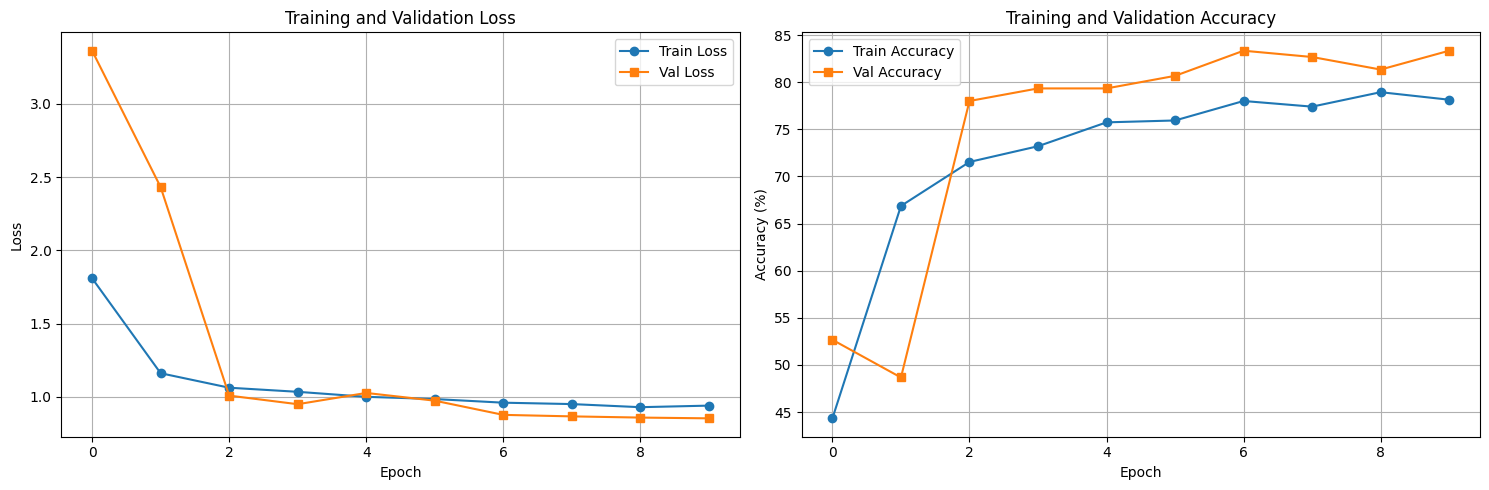

Best model loaded from epoch 7
Best validation accuracy: 83.33%


Final evaluation: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]



Final Validation Accuracy: 83.33%


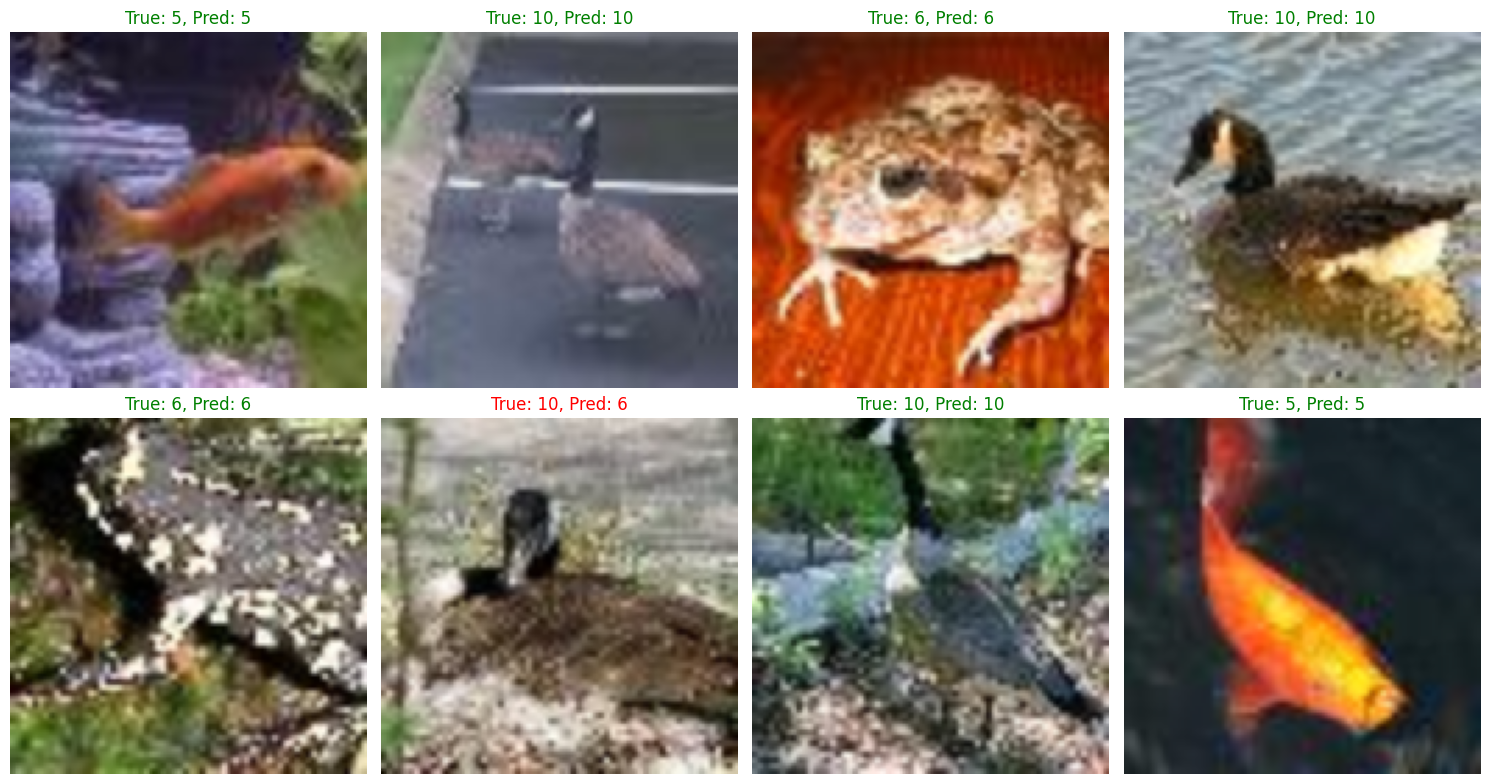

Параметры модели: 1.96M
Лучшая валидационная точность: 83.33%
Финальная валидационная точность: 83.33%


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_classifier['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history_classifier['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_classifier['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history_classifier['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Final evaluation'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
print(f'\nFinal Validation Accuracy: {final_acc*100:.2f}%')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
model.eval()

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        img, label = val_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        _, pred = output.max(1)

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        color = 'green' if pred.item() == label else 'red'
        ax.set_title(f'True: {label}, Pred: {pred.item()}', color=color)
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Параметры модели: {total_params/1e6:.2f}M')
print(f'Лучшая валидационная точность: {checkpoint["val_acc"]:.2f}%')
print(f'Финальная валидационная точность: {final_acc*100:.2f}%')

Часть 2: Базовая U-Net на датасете "Луна" - в отдельном блокноте